In [5]:


import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
from tqdm import tqdm
import numpy as np



from resnetpass import resnet18_cbam

In [6]:
device = torch.device('cuda:0')
class_order_file = 'class_order.pth'

In [7]:
!pip install pytorch-metric-learning

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [9]:
model = resnet18_cbam(pretrained=False)

In [10]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ca): ChannelAttention(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (max_pool): AdaptiveMaxPool2d(output_size=1)
        (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (relu1): ReLU()
        (fc2

In [11]:
model.fc = nn.Linear(512,512)

In [12]:
!pwd

/home/ubuntu/lialib/colab


In [13]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3060', major=8, minor=6, total_memory=12044MB, multi_processor_count=28)

In [14]:
#model.load_state_dict(model_state_dict['rn18'])
import os

if os.path.isfile(class_order_file ):
    class_order = torch.load(class_order_file)
else:
    class_order = torch.randperm(100)
    torch.save(class_order,class_order_file)

In [15]:
class_order

tensor([30, 43, 94, 73, 34, 67, 62, 33, 61, 15, 78, 28, 41, 68, 57,  0,  3, 22,
         5,  2, 65, 26, 54, 32, 24, 83, 72, 13, 29, 49, 98, 20, 31, 82, 71, 44,
        42, 91, 40, 99, 23, 97,  6, 90, 45, 63, 60, 56, 87, 47, 79, 51, 58, 17,
        16, 96, 52, 75, 92, 69, 35, 38, 53, 25,  1, 80, 39, 88, 21, 74, 36, 19,
        11, 10, 76, 89, 59, 37,  9, 14, 81, 95, 77, 64, 70, 46, 55, 66, 86, 85,
        18, 12,  7, 48, 93,  4, 27,  8, 50, 84])

In [16]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
])

In [17]:
ds_train = datasets.CIFAR100(root='./data', train=True, download=True, transform=preprocess)
ds_test  = datasets.CIFAR100(root='./data', train=False, download=True, transform=preprocess)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
def instances_from_classes(dataset, class_order):
    subset = []
    for i in range(len(dataset)):
        _, label = dataset[i]
        if label in class_order:
            subset.append(i)
    return subset


In [19]:
set_train = instances_from_classes(ds_train,class_order[:50])
set_test  = np.array(instances_from_classes(ds_test, class_order[:50]))

In [20]:
set_test.shape

(5000,)

In [21]:
sub_sample_train = sorted(np.random.permutation(set_train)[:300])
sub_sample_test  = sorted(np.random.permutation(set_test)[:300])

In [22]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=64, sampler=torch.utils.data.SubsetRandomSampler(set_train))
dl_test = torch.utils.data.DataLoader(ds_test,  batch_size=64, sampler=torch.utils.data.SubsetRandomSampler(set_test))
dl_sub_train = torch.utils.data.DataLoader(ds_train,  batch_size=64, sampler=torch.utils.data.SubsetRandomSampler(sub_sample_train))
dl_sub_test = torch.utils.data.DataLoader(ds_test,  batch_size=64, sampler=torch.utils.data.SubsetRandomSampler(sub_sample_test))

In [23]:
x,y = next(iter(dl_train))

In [24]:
y.shape

torch.Size([64])

In [25]:
y

tensor([71, 73, 67,  3, 83, 54, 68, 83, 47, 82, 30, 68, 44, 24, 61, 20, 68,  2,
        68, 65, 62, 24, 23, 13, 94, 32, 68,  6, 45, 44, 15, 90, 13, 71, 73, 24,
        62,  0,  5, 33, 68, 44, 62, 97, 49, 44,  3, 45, 13, 83, 32, 65, 90, 40,
        31, 91, 62, 28,  6, 47, 33, 56, 41, 22])

In [26]:
from pytorch_metric_learning import losses
loss_func = losses.ArcFaceLoss(num_classes=100,embedding_size=512)


In [27]:
!pip install wandb

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [28]:
import wandb

In [29]:
wandb.init(
    # set the wandb project where this run will be logged
    project="clip+dmil",
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: edson-matsubara (lablia). Use `wandb login --relogin` to force relogin


In [30]:

opt = optim.Adam(model.parameters(),lr=0.001)

In [31]:
scheduler = optim.lr_scheduler.MultiStepLR(opt,milestones=[45,90],gamma=0.1)

In [32]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ca): ChannelAttention(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (max_pool): AdaptiveMaxPool2d(output_size=1)
        (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (relu1): ReLU()
        (fc2

In [33]:
emb_batch = model(x.to(device))

In [34]:
from sklearn.manifold import TSNE

In [35]:
# given a batch of instances create a surrounding sample of instances
def create_surrounding_batch(batch,batch_y, num_surrounding=100, size=0.001):
    surrounding_batch = []
    surrounding_batch_y = []
    for i in range(len(batch)):
        
        instances_sorrounding = batch[i]+(torch.randn(num_surrounding,512)*size).to(batch.device)
        surrounding_batch.append(instances_sorrounding)
        surrounding_batch_y.append(batch_y[i].repeat(num_surrounding))
    return torch.cat(surrounding_batch), torch.cat(surrounding_batch_y)

In [36]:
batch_emb, batch_y = create_surrounding_batch(emb_batch,y)

In [37]:
batch_emb.shape

torch.Size([6400, 512])

In [38]:
batch_y.shape

torch.Size([6400])

In [39]:

tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(batch_emb.to('cpu').detach().numpy())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6400 samples in 0.002s...
[t-SNE] Computed neighbors for 6400 samples in 1.554s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6400
[t-SNE] Computed conditional probabilities for sample 2000 / 6400
[t-SNE] Computed conditional probabilities for sample 3000 / 6400
[t-SNE] Computed conditional probabilities for sample 4000 / 6400
[t-SNE] Computed conditional probabilities for sample 5000 / 6400
[t-SNE] Computed conditional probabilities for sample 6000 / 6400
[t-SNE] Computed conditional probabilities for sample 6400 / 6400
[t-SNE] Mean sigma: 0.005549
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.166233
[t-SNE] KL divergence after 1000 iterations: 0.933353


In [40]:
from matplotlib import cm
import matplotlib.pyplot as plt

In [41]:
def tsne_proj(batch_emb, batch_y):
    tsne = TSNE(2, verbose=1)
    tsne_proj = tsne.fit_transform(batch_emb.to('cpu').detach().numpy())
    cmap = cm.get_cmap('tab10')
    fig, ax = plt.subplots(figsize=(15,15))
    num_categories = 100
    for lab in range(num_categories):
        if lab in batch_y:
            indices = batch_y==lab
            ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
    ax.legend(fontsize='large', markerscale=2)
    plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6400 samples in 0.002s...


[t-SNE] Computed neighbors for 6400 samples in 2.151s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6400
[t-SNE] Computed conditional probabilities for sample 2000 / 6400
[t-SNE] Computed conditional probabilities for sample 3000 / 6400
[t-SNE] Computed conditional probabilities for sample 4000 / 6400
[t-SNE] Computed conditional probabilities for sample 5000 / 6400
[t-SNE] Computed conditional probabilities for sample 6000 / 6400
[t-SNE] Computed conditional probabilities for sample 6400 / 6400
[t-SNE] Mean sigma: 0.005549
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.161854
[t-SNE] KL divergence after 1000 iterations: 0.931484


/tmp/ipykernel_88448/3286734825.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


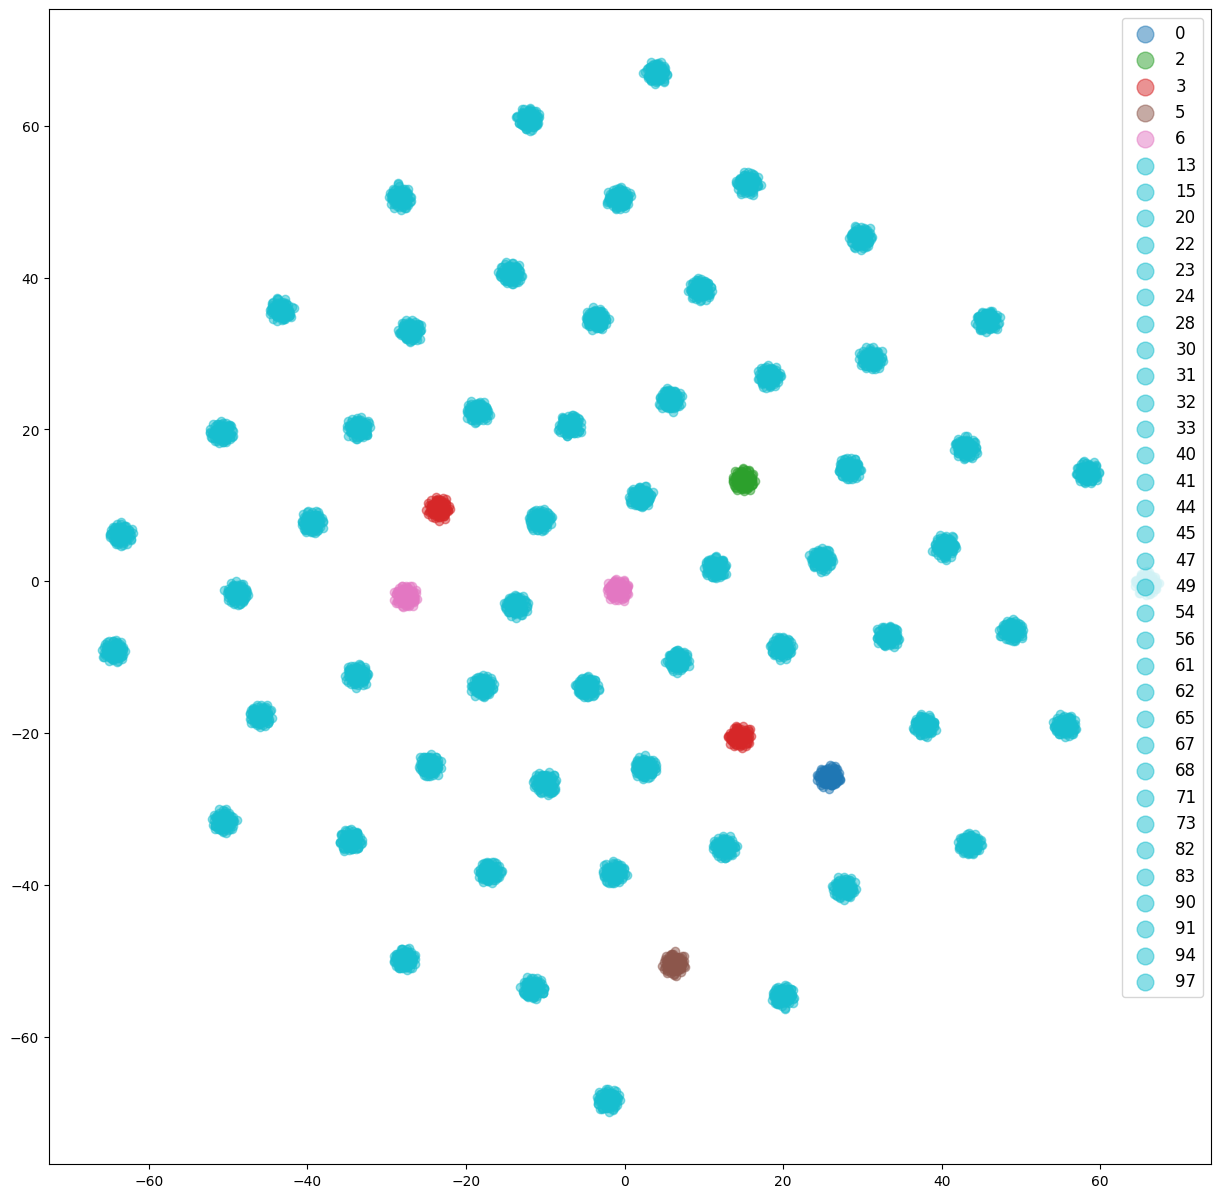

In [42]:
tsne_proj(batch_emb,batch_y)

In [43]:
def get_embeddings(lmodel,dl):
    lmodel.to(device)
    loop = tqdm(dl)
    lpred = []
    ly = []
    with torch.no_grad():
        for x,y in loop:
            x = x.to(device)
            y = y.to(device)
            pred = lmodel(x)
            lpred = lpred+pred.tolist()
            ly    = ly + y.tolist()
    return lpred,ly

In [44]:
import sklearn.neighbors as neighbors

In [45]:
from sklearn.metrics import classification_report

In [46]:
def pred_knn_model(model,dl_local_train,dl_local_test):
    train_emb,train_y = get_embeddings(model,dl_local_train)
    test_emb,test_y   = get_embeddings(model,dl_local_test)
    train_emb  = np.array(train_emb)
    train_y    = np.array(train_y)
    test_emb   = np.array(test_emb)
    test_y     = np.array(test_y)
    clf = neighbors.KNeighborsClassifier(n_neighbors=1,weights='distance')
    clf.fit(train_emb,train_y.T)
    pred = clf.predict(test_emb)
    return pred,test_y


In [47]:
pred,test_y = pred_knn_model(model,dl_sub_train,dl_sub_test)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 52.42it/s]


In [48]:
pred.shape,test_y.T.shape

((300,), (300,))

In [49]:
print(classification_report(test_y.T,pred))

              precision    recall  f1-score   support

           0       0.20      0.17      0.18         6
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         6
           5       0.33      0.09      0.14        11
           6       0.00      0.00      0.00         4
          13       0.17      0.50      0.25         4
          15       0.00      0.00      0.00         3
          20       0.33      0.17      0.22         6
          22       0.00      0.00      0.00         4
          23       0.00      0.00      0.00         6
          24       0.20      0.20      0.20         5
          26       0.00      0.00      0.00         3
          28       0.00      0.00      0.00         8
          29       0.00      0.00      0.00         3
          30       0.00      0.00      0.00         7
          31       0.20      0.11      0.14         9
          32       0.00      0.00      0.00         7
          33       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
import sklearn.metrics as metrics

In [52]:
model.to(device)
loss_func.to(device)
loss_train = []
for epoch in range(100):
    model.train()
    loop = tqdm(dl_train)
    lloss = []
    for data, labels in loop:
        data = data.to(device)
        labels = labels.to(device)
        opt.zero_grad()
        embeddings = model(data)
        batch_emb, batch_y = create_surrounding_batch(embeddings,labels)
        loss = loss_func(batch_emb, batch_y)
        loss.backward()
        lloss.append(loss.item())
        opt.step()
    scheduler.step()
    if epoch %10 == 0:
        pred,labels = pred_knn_model(model,dl_sub_train,dl_sub_test)
        f1 = metrics.f1_score(labels,pred,average='macro')
        precision = metrics.precision_score(labels,pred,average='macro')
        recall = metrics.recall_score(labels,pred,average='macro')
        accuracy = metrics.accuracy_score(labels,pred)
        wandb.log({'precision':precision,'recall':recall,'f1':f1,'accuracy':accuracy},step=epoch)
        print(classification_report(labels.T,pred))
    loss_train.append(np.mean(lloss))
    print(f"loss {loss_train[-1]}")
    wandb.log({'loss_train':loss_train[-1]},step=epoch)

100%|██████████| 5/5 [00:00<00:00, 57.93it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-

              precision    recall  f1-score   support

           0       0.14      0.17      0.15         6
           2       0.14      0.14      0.14         7
           3       0.00      0.00      0.00         6
           5       0.25      0.09      0.13        11
           6       0.00      0.00      0.00         4
          13       0.00      0.00      0.00         4
          15       0.00      0.00      0.00         3
          20       0.45      0.83      0.59         6
          22       0.00      0.00      0.00         4
          23       0.25      0.33      0.29         6
          24       0.67      0.40      0.50         5
          26       0.00      0.00      0.00         3
          28       0.00      0.00      0.00         8
          29       0.00      0.00      0.00         3
          30       0.22      0.29      0.25         7
          31       0.20      0.11      0.14         9
          32       0.00      0.00      0.00         7
          33       0.40    

100%|██████████| 391/391 [00:30<00:00, 12.74it/s]


loss 29.871611685399206


100%|██████████| 391/391 [00:30<00:00, 12.61it/s]


loss 27.495304702797814


100%|██████████| 391/391 [00:30<00:00, 12.64it/s]


loss 24.8213320290646


100%|██████████| 391/391 [00:32<00:00, 11.97it/s]


loss 22.11002634248465


100%|██████████| 391/391 [00:31<00:00, 12.25it/s]


loss 19.146809604771608


100%|██████████| 391/391 [00:32<00:00, 12.14it/s]


loss 16.243266993471423


100%|██████████| 391/391 [00:31<00:00, 12.58it/s]


loss 13.227958674321089


100%|██████████| 391/391 [00:32<00:00, 11.97it/s]


loss 10.440570916666095


100%|██████████| 391/391 [00:30<00:00, 12.69it/s]


loss 7.738970957753604


100%|██████████| 5/5 [00:00<00:00, 59.63it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           2       0.80      0.57      0.67         7
           3       0.25      0.17      0.20         6
           5       1.00      0.73      0.84        11
           6       0.33      0.25      0.29         4
          13       1.00      0.75      0.86         4
          15       1.00      0.33      0.50         3
          20       0.60      1.00      0.75         6
          22       1.00      0.25      0.40         4
          23       0.67      0.67      0.67         6
          24       1.00      1.00      1.00         5
          26       0.50      0.33      0.40         3
          28       1.00      0.88      0.93         8
          29       1.00      0.33      0.50         3
          30       0.25      0.14      0.18         7
          31       0.71      0.56      0.63         9
          32       1.00      0.43      0.60         7
          33       0.56    

100%|██████████| 391/391 [00:31<00:00, 12.29it/s]


loss 3.7081524767839085


100%|██████████| 391/391 [00:32<00:00, 12.00it/s]


loss 2.6074497581976455


100%|██████████| 391/391 [00:31<00:00, 12.46it/s]


loss 1.8905426094599087


100%|██████████| 391/391 [00:32<00:00, 12.12it/s]


loss 1.5915775884638357


100%|██████████| 391/391 [00:32<00:00, 12.13it/s]


loss 1.292684659485698


100%|██████████| 391/391 [00:31<00:00, 12.49it/s]


loss 1.0656594406013065


100%|██████████| 391/391 [00:31<00:00, 12.39it/s]


loss 1.053404365135047


100%|██████████| 391/391 [00:31<00:00, 12.29it/s]


loss 0.9015897170514288


100%|██████████| 391/391 [00:31<00:00, 12.45it/s]


loss 0.9672037515065173


100%|██████████| 5/5 [00:00<00:00, 58.24it/s]


              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           2       1.00      0.29      0.44         7
           3       0.33      0.17      0.22         6
           5       1.00      0.36      0.53        11
           6       0.00      0.00      0.00         4
          13       0.13      0.75      0.22         4
          15       1.00      0.33      0.50         3
          20       1.00      1.00      1.00         6
          22       0.67      0.50      0.57         4
          23       1.00      0.50      0.67         6
          24       1.00      0.80      0.89         5
          26       0.00      0.00      0.00         3
          28       1.00      0.88      0.93         8
          29       1.00      0.33      0.50         3
          30       0.75      0.43      0.55         7
          31       0.78      0.78      0.78         9
          32       1.00      0.43      0.60         7
          33       0.75    

100%|██████████| 391/391 [00:31<00:00, 12.48it/s]


loss 0.6622467748451587


100%|██████████| 391/391 [00:30<00:00, 12.79it/s]


loss 0.6848082193673667


100%|██████████| 391/391 [00:31<00:00, 12.55it/s]


loss 0.7009789846608858


100%|██████████| 391/391 [00:31<00:00, 12.50it/s]


loss 0.6843131880140136


100%|██████████| 391/391 [00:31<00:00, 12.46it/s]


loss 0.696562154986717


100%|██████████| 391/391 [00:30<00:00, 12.75it/s]


loss 0.680950291767714


100%|██████████| 391/391 [00:31<00:00, 12.32it/s]


loss 0.4768608643273201


100%|██████████| 391/391 [00:38<00:00, 10.17it/s]


loss 0.5099412133748098


100%|██████████| 391/391 [00:46<00:00,  8.47it/s]


loss 0.5374954009257124


100%|██████████| 5/5 [00:00<00:00, 55.12it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-

              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           2       1.00      0.71      0.83         7
           3       0.50      0.33      0.40         6
           5       0.88      0.64      0.74        11
           6       0.04      0.75      0.08         4
          13       0.75      0.75      0.75         4
          15       0.50      0.33      0.40         3
          20       1.00      1.00      1.00         6
          22       0.67      0.50      0.57         4
          23       0.50      0.67      0.57         6
          24       1.00      1.00      1.00         5
          26       0.00      0.00      0.00         3
          28       1.00      0.88      0.93         8
          29       0.33      0.33      0.33         3
          30       0.83      0.71      0.77         7
          31       0.83      0.56      0.67         9
          32       0.67      0.29      0.40         7
          33       0.80    

100%|██████████| 391/391 [00:43<00:00,  9.03it/s]


loss 0.5548111932099704


100%|██████████| 391/391 [00:39<00:00, 10.02it/s]


loss 0.546079540378688


100%|██████████| 391/391 [00:37<00:00, 10.45it/s]


loss 0.4526333562029964


100%|██████████| 391/391 [00:35<00:00, 10.91it/s]


loss 0.4778043343611133


100%|██████████| 391/391 [00:36<00:00, 10.72it/s]


loss 0.3973801289676138


100%|██████████| 391/391 [00:37<00:00, 10.54it/s]


loss 0.3960533143739309


100%|██████████| 391/391 [00:36<00:00, 10.68it/s]


loss 0.39758398606563394


100%|██████████| 391/391 [00:38<00:00, 10.22it/s]


loss 0.4737152686864233


100%|██████████| 391/391 [00:36<00:00, 10.77it/s]


loss 0.38261002859831944


100%|██████████| 5/5 [00:00<00:00, 56.96it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-

              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           2       0.86      0.86      0.86         7
           3       0.67      0.33      0.44         6
           5       0.80      0.36      0.50        11
           6       0.00      0.00      0.00         4
          13       0.75      0.75      0.75         4
          15       1.00      0.67      0.80         3
          20       0.86      1.00      0.92         6
          22       1.00      0.50      0.67         4
          23       0.50      0.67      0.57         6
          24       1.00      0.80      0.89         5
          26       0.00      0.00      0.00         3
          28       1.00      0.88      0.93         8
          29       0.33      0.33      0.33         3
          30       1.00      0.29      0.44         7
          31       0.83      0.56      0.67         9
          32       1.00      0.43      0.60         7
          33       0.50    

100%|██████████| 391/391 [00:35<00:00, 11.08it/s]


loss 0.39830577431206143


100%|██████████| 391/391 [00:36<00:00, 10.82it/s]


loss 0.4085494366005811


100%|██████████| 391/391 [00:38<00:00, 10.23it/s]


loss 0.330255382243083


100%|██████████| 391/391 [00:37<00:00, 10.44it/s]


loss 0.13100841177059958


100%|██████████| 391/391 [00:38<00:00, 10.21it/s]


loss 0.04764961757202325


100%|██████████| 391/391 [00:40<00:00,  9.59it/s]


loss 0.039923269603856365


100%|██████████| 391/391 [00:38<00:00, 10.15it/s]


loss 0.028565463688149523


100%|██████████| 391/391 [00:40<00:00,  9.68it/s]


loss 0.028826095252473483


100%|██████████| 391/391 [00:36<00:00, 10.74it/s]


loss 0.02693308710970361


100%|██████████| 5/5 [00:00<00:00, 54.71it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-

              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           2       0.75      0.43      0.55         7
           3       0.50      0.33      0.40         6
           5       0.83      0.45      0.59        11
           6       0.03      0.50      0.05         4
          13       0.75      0.75      0.75         4
          15       1.00      0.67      0.80         3
          20       1.00      1.00      1.00         6
          22       1.00      0.50      0.67         4
          23       0.29      0.67      0.40         6
          24       0.83      1.00      0.91         5
          26       0.00      0.00      0.00         3
          28       0.88      0.88      0.88         8
          29       0.25      0.33      0.29         3
          30       1.00      0.57      0.73         7
          31       0.71      0.56      0.63         9
          32       1.00      0.29      0.44         7
          33       0.57    

100%|██████████| 391/391 [00:35<00:00, 11.15it/s]


loss 0.025444966019041924


100%|██████████| 391/391 [00:33<00:00, 11.77it/s]


loss 0.022319700470363336


100%|██████████| 391/391 [00:38<00:00, 10.04it/s]


loss 0.025247189430091195


100%|██████████| 391/391 [00:37<00:00, 10.53it/s]


loss 0.021930857697148066


100%|██████████| 391/391 [00:35<00:00, 11.07it/s]


loss 0.022621327147567812


100%|██████████| 391/391 [00:35<00:00, 11.08it/s]


loss 0.019739837647276357


100%|██████████| 391/391 [00:34<00:00, 11.18it/s]


loss 0.02389817719880427


100%|██████████| 391/391 [00:34<00:00, 11.47it/s]


loss 0.022319580198374583


100%|██████████| 391/391 [00:41<00:00,  9.46it/s]


loss 0.0213694668396095


100%|██████████| 5/5 [00:00<00:00, 54.87it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-

              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           2       1.00      0.43      0.60         7
           3       0.50      0.33      0.40         6
           5       0.86      0.55      0.67        11
           6       0.00      0.00      0.00         4
          13       0.05      1.00      0.09         4
          15       1.00      0.33      0.50         3
          20       1.00      1.00      1.00         6
          22       1.00      0.75      0.86         4
          23       0.57      0.67      0.62         6
          24       1.00      1.00      1.00         5
          26       0.00      0.00      0.00         3
          28       1.00      0.88      0.93         8
          29       0.25      0.33      0.29         3
          30       0.80      0.57      0.67         7
          31       0.83      0.56      0.67         9
          32       1.00      0.43      0.60         7
          33       0.80    

100%|██████████| 391/391 [00:35<00:00, 11.01it/s]


loss 0.017000701777232678


100%|██████████| 391/391 [00:36<00:00, 10.72it/s]


loss 0.017084153457794845


100%|██████████| 391/391 [00:39<00:00,  9.83it/s]


loss 0.01944467436087251


100%|██████████| 391/391 [00:46<00:00,  8.46it/s]


loss 0.018738264766405038


100%|██████████| 391/391 [00:44<00:00,  8.86it/s]


loss 0.02009802707292311


100%|██████████| 391/391 [00:44<00:00,  8.75it/s]


loss 0.017706380914310184


100%|██████████| 391/391 [00:47<00:00,  8.26it/s]


loss 0.0163968966777652


100%|██████████| 391/391 [00:42<00:00,  9.10it/s]


loss 0.011810102578251958


100%|██████████| 391/391 [00:40<00:00,  9.68it/s]


loss 0.014568994548517135


100%|██████████| 5/5 [00:00<00:00, 57.98it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-

              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           2       0.75      0.43      0.55         7
           3       0.50      0.33      0.40         6
           5       0.86      0.55      0.67        11
           6       0.00      0.00      0.00         4
          13       0.60      0.75      0.67         4
          15       1.00      0.33      0.50         3
          20       1.00      1.00      1.00         6
          22       1.00      0.50      0.67         4
          23       1.00      0.67      0.80         6
          24       1.00      1.00      1.00         5
          26       0.00      0.00      0.00         3
          28       1.00      1.00      1.00         8
          29       1.00      0.33      0.50         3
          30       0.50      0.14      0.22         7
          31       0.83      0.56      0.67         9
          32       1.00      0.29      0.44         7
          33       0.57    

100%|██████████| 391/391 [00:45<00:00,  8.53it/s]


loss 0.013972186288573657


100%|██████████| 391/391 [00:40<00:00,  9.65it/s]


loss 0.013431696870225503


100%|██████████| 391/391 [00:38<00:00, 10.14it/s]


loss 0.012634136136132948


100%|██████████| 391/391 [00:39<00:00, 10.00it/s]


loss 0.0122766265396417


100%|██████████| 391/391 [00:37<00:00, 10.43it/s]


loss 0.015103005988272074


100%|██████████| 391/391 [00:31<00:00, 12.44it/s]


loss 0.010967390405956795


100%|██████████| 391/391 [00:30<00:00, 12.63it/s]


loss 0.013060233800474297


100%|██████████| 391/391 [00:30<00:00, 12.85it/s]


loss 0.01179290772936738


100%|██████████| 391/391 [00:29<00:00, 13.45it/s]


loss 0.011832497356196894


100%|██████████| 5/5 [00:00<00:00, 61.86it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-

              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           2       0.83      0.71      0.77         7
           3       0.50      0.33      0.40         6
           5       0.86      0.55      0.67        11
           6       0.00      0.00      0.00         4
          13       0.75      0.75      0.75         4
          15       1.00      0.33      0.50         3
          20       1.00      1.00      1.00         6
          22       1.00      0.75      0.86         4
          23       0.80      0.67      0.73         6
          24       1.00      0.80      0.89         5
          26       0.00      0.00      0.00         3
          28       1.00      0.88      0.93         8
          29       0.04      1.00      0.07         3
          30       0.67      0.29      0.40         7
          31       0.83      0.56      0.67         9
          32       1.00      0.57      0.73         7
          33       0.75    

100%|██████████| 391/391 [00:30<00:00, 13.00it/s]


loss 0.01200943751624771


100%|██████████| 391/391 [00:28<00:00, 13.54it/s]


loss 0.011984161865722407


100%|██████████| 391/391 [00:31<00:00, 12.40it/s]


loss 0.009672064961300736


100%|██████████| 391/391 [00:31<00:00, 12.55it/s]


loss 0.010757287956111472


100%|██████████| 391/391 [00:30<00:00, 12.99it/s]


loss 0.015935757128625116


100%|██████████| 391/391 [00:30<00:00, 12.75it/s]


loss 0.010047721609463106


100%|██████████| 391/391 [00:31<00:00, 12.59it/s]


loss 0.010268498006995226


100%|██████████| 391/391 [00:30<00:00, 12.90it/s]


loss 0.013104745519140263


100%|██████████| 391/391 [00:30<00:00, 12.70it/s]


loss 0.00807158841551734


100%|██████████| 5/5 [00:00<00:00, 57.22it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-

              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           2       1.00      0.29      0.44         7
           3       0.50      0.33      0.40         6
           5       0.88      0.64      0.74        11
           6       0.00      0.00      0.00         4
          13       1.00      0.75      0.86         4
          15       1.00      0.33      0.50         3
          20       1.00      1.00      1.00         6
          22       1.00      0.75      0.86         4
          23       1.00      0.50      0.67         6
          24       1.00      0.80      0.89         5
          26       0.00      0.00      0.00         3
          28       1.00      0.88      0.93         8
          29       0.15      0.67      0.25         3
          30       0.80      0.57      0.67         7
          31       0.83      0.56      0.67         9
          32       1.00      0.43      0.60         7
          33       0.80    

100%|██████████| 391/391 [00:32<00:00, 12.00it/s]


loss 0.007817606256260653


100%|██████████| 391/391 [00:31<00:00, 12.32it/s]


loss 0.007010312763589393


100%|██████████| 391/391 [00:32<00:00, 11.96it/s]


loss 0.006858431029028099


100%|██████████| 391/391 [00:31<00:00, 12.37it/s]


loss 0.007504959610532588


100%|██████████| 391/391 [00:32<00:00, 12.13it/s]


loss 0.006884641757266491


100%|██████████| 391/391 [00:30<00:00, 12.72it/s]


loss 0.007589253448502189


100%|██████████| 391/391 [00:30<00:00, 12.64it/s]


loss 0.0064303064095827004


100%|██████████| 391/391 [00:31<00:00, 12.22it/s]


loss 0.006891982571650333


100%|██████████| 391/391 [00:32<00:00, 12.16it/s]

loss 0.0069340423137396745


In [53]:
epoch

99

In [ ]:
pred,labels = pred_knn_model(model,dl_train,dl_test)

In [55]:
f1 = metrics.f1_score(labels,pred,average='macro')
precision = metrics.precision_score(labels,pred,average='macro')
recall = metrics.recall_score(labels,pred,average='macro')
accuracy = metrics.accuracy_score(labels,pred)

In [56]:
print(f"precision {precision}")
print(f"recall {recall}")
print(f"f1 {f1}")
print(f"accuracy {accuracy}")

precision 0.6932405964656521
recall 0.6162000000000001
f1 0.6366743649148952
accuracy 0.6162


In [57]:
wandb.log({'precision':precision,'recall':recall,'f1':f1,'accuracy':accuracy},step=epoch)
print(classification_report(labels.T,pred))

              precision    recall  f1-score   support

           0       0.91      0.79      0.84       100
           2       0.69      0.45      0.55       100
           3       0.48      0.31      0.38       100
           5       0.77      0.62      0.69       100
           6       0.78      0.58      0.67       100
          13       0.82      0.67      0.74       100
          15       0.73      0.44      0.55       100
          20       0.95      0.79      0.86       100
          22       0.74      0.52      0.61       100
          23       0.75      0.70      0.73       100
          24       0.26      0.89      0.40       100
          26       0.68      0.52      0.59       100
          28       0.89      0.75      0.82       100
          29       0.71      0.60      0.65       100
          30       0.64      0.58      0.61       100
          31       0.19      0.73      0.30       100
          32       0.71      0.39      0.50       100
          33       0.72    

In [ ]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3060', major=8, minor=6, total_memory=12044MB, multi_processor_count=28)

In [ ]:
torch.save({'rn18':model.state_dict(),'class_order':class_order,'loss_train':loss_train},'rn18_dml_pass_100epochs.pth')